In [38]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Check if CUDA is available
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    # Print the number of available GPUs
    print(f"GPU Count: {torch.cuda.device_count()}")
    # Print the name of the current GPU
    print(f"Current GPU Name: {torch.cuda.get_device_name(0)}")
    
    # Optional: Run a test tensor on the GPU
    x = torch.randn(3, 3)
    x = x.to('cuda')
    print(f"Test Tensor Device: {x.device}")


PyTorch Version: 2.10.0+cu126
CUDA Available: True
GPU Count: 1
Current GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
Test Tensor Device: cuda:0


In [22]:
def create_matrices(size, device):
    assert device in ['cuda', 'mps', 'cpu']
    d = torch.device(device)
    A = torch.randn([size, size], dtype=torch.float32, device=d)
    B = torch.randn([size, size], dtype=torch.float32, device=d)
    return A, B


A, B = create_matrices(10000, 'cuda')
print("Matrix A: ")
print(A.shape)
print(A.dtype)
print(A.device)
print("Matrix B: ")
print(B.shape)
print(B.dtype)
print(B.device)


Matrix A: 
torch.Size([10000, 10000])
torch.float32
cuda:0
Matrix B: 
torch.Size([10000, 10000])
torch.float32
cuda:0


In [29]:
def benchmark_matmul(A, B):
    torch.cuda.synchronize()
    start = time.perf_counter()
    C = torch.mm(A, B)
    torch.cuda.synchronize()
    end = time.perf_counter()
    return (end - start) * 1000

benchmark_matmul(A, B)

295.16584699740633

CUDA Benchmark:
10x10 = 144.8067169985734
10000x10000 = 578.9596600006917

CPU Benchmark:
10x10 = 12.376146994938608
10000x10000 = 4068.491357000312


In [48]:
def compare_pus(sizes):
    results = {
        "sizes" : sizes, 
        "cpu_times": [],
        "gpu_times" : [],
        "speedups" : []
    }
    print(f"{'Size ':>8} | {'CPU (ms) ':>12} | {'GPU (ms) ':>12} | {'Speedup':>10}")
    for size in sizes:
        #CPU Test
        A_cpu, B_cpu = create_matrices(size, 'cpu')
        cpu_time = benchmark_matmul(A_cpu, B_cpu)

        #GPU Test
        A_gpu, B_gpu = create_matrices(size, 'cuda')
        gpu_time = benchmark_matmul(A_gpu, B_gpu)

        speedup = cpu_time/gpu_time

        results["cpu_times"].append(cpu_time)
        results["gpu_times"].append(gpu_time)
        results["speedups"].append(speedup)
        print(f"{size:>8} | {cpu_time :>10.2f}ms | {gpu_time :>10.2f}ms | {speedup :>9.2f}x")
    return results
        
sizes = [512, 1024, 2048, 4096, 8192]
compare_pus(sizes)



   Size  |    CPU (ms)  |    GPU (ms)  |    Speedup
     512 |       1.80ms |       1.54ms |      1.17x
    1024 |       6.32ms |       5.27ms |      1.20x
    2048 |      40.74ms |      21.75ms |      1.87x
    4096 |     335.84ms |     186.92ms |      1.80x
    8192 |    2225.92ms |     399.13ms |      5.58x


{'sizes': [512, 1024, 2048, 4096, 8192],
 'cpu_times': [1.8003959994530305,
  6.322852001176216,
  40.74201900220942,
  335.84200000041164,
  2225.915323004301],
 'gpu_times': [1.5413419969263487,
  5.265483996481635,
  21.754902001703158,
  186.9166810065508,
  399.12772700336063],
 'speedups': [1.1680704237237887,
  1.200811170521287,
  1.8727741912613436,
  1.7967470757125286,
  5.576949864436652]}

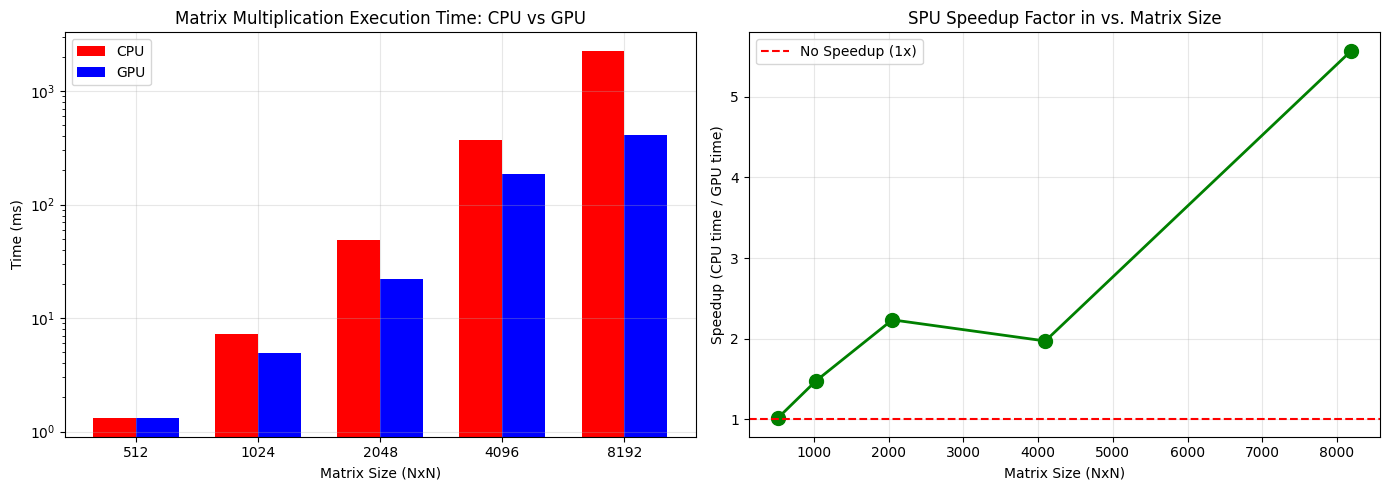

In [ ]:
data = compare_pus(sizes)

fig, axes = plt.subplots(1,2,figsize=(14,5))

ax1 = axes[0]
x = np.arange(len(sizes))
width = 0.35

bars1 = ax1.bar(x-width/2, data['cpu_times'], width, label="CPU", color='red')
bars2 = ax1.bar(x+width/2, data['gpu_times'], width, label='GPU', color='blue')

ax1.set_xlabel('Matrix Size (NxN)')
ax1.set_ylabel('Time (ms)')
ax1.set_title('Matrix Multiplication Execution Time: CPU vs GPU')
ax1.set_xticks(x)
ax1.set_xticklabels([str(s) for s in sizes])
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(sizes, data['speedups'], 'go-', linewidth=2, markersize=10)
ax2.axhline(y=1, color='r', linestyle='--', label='No Speedup (1x)')
ax2.set_xlabel('Matrix Size (NxN)')
ax2.set_ylabel('Speedup (CPU time / GPU time)')
ax2.set_title('SPU Speedup Factor in vs. Matrix Size')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
#plt.savefig('cuda_vs_cpu_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

Why is CUDA faster than a CPU for large scale matrix calculations?

smthsmthsmths

1. What is the maximum speedup you observed? At what matrix size did this occur?


2. Why is the synchronize() call necessary for accurate GPU timing? What would
happen if you removed it?


3. Examine your results closely. Do you notice any trends or patterns in how speedup changes with matrix size? Research the architecture of your specific GPU or Apple Silicon device (number of cores, memory bandwidth, compute units, etc.) and write a hypothesis explaining why your timing results look the way they do. What architectural features might account for the performance characteristics you observed?


4. Based on your results, at approximately what matrix size does using a GPU
become worthwhile? Explain your reasoning.
